In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import skew, kurtosis
import seaborn as sns

import sys
sys.path.append('..')
from Scripts.preprocess_data import load_parquet
from Scripts.analysis import plot_ticker
from Scripts.analysis import removeNSE
from Scripts.analysis import groupByColumn
from Scripts.analysis import rotateXLabels
from Scripts.analysis import graphTuning

In [18]:
stock_data=load_parquet()

<h1><b>Monthly Closing Price Trends — Bank-wise Comparison</b></h1>



In [19]:
stock_data_byMonth=(
   groupByColumn(stock_data, 'ticker')
    .apply(lambda x: x.set_index('date').resample('ME').agg({'close': 'last'}),include_groups=False)
    .reset_index()
)
stock_data_byMonth.dropna(subset=['close'], inplace=True)
stock_data_byMonth.set_index('date')
stock_data_byMonth['ticker'] = stock_data_byMonth['ticker'].str.replace('.NS', '', regex=False)



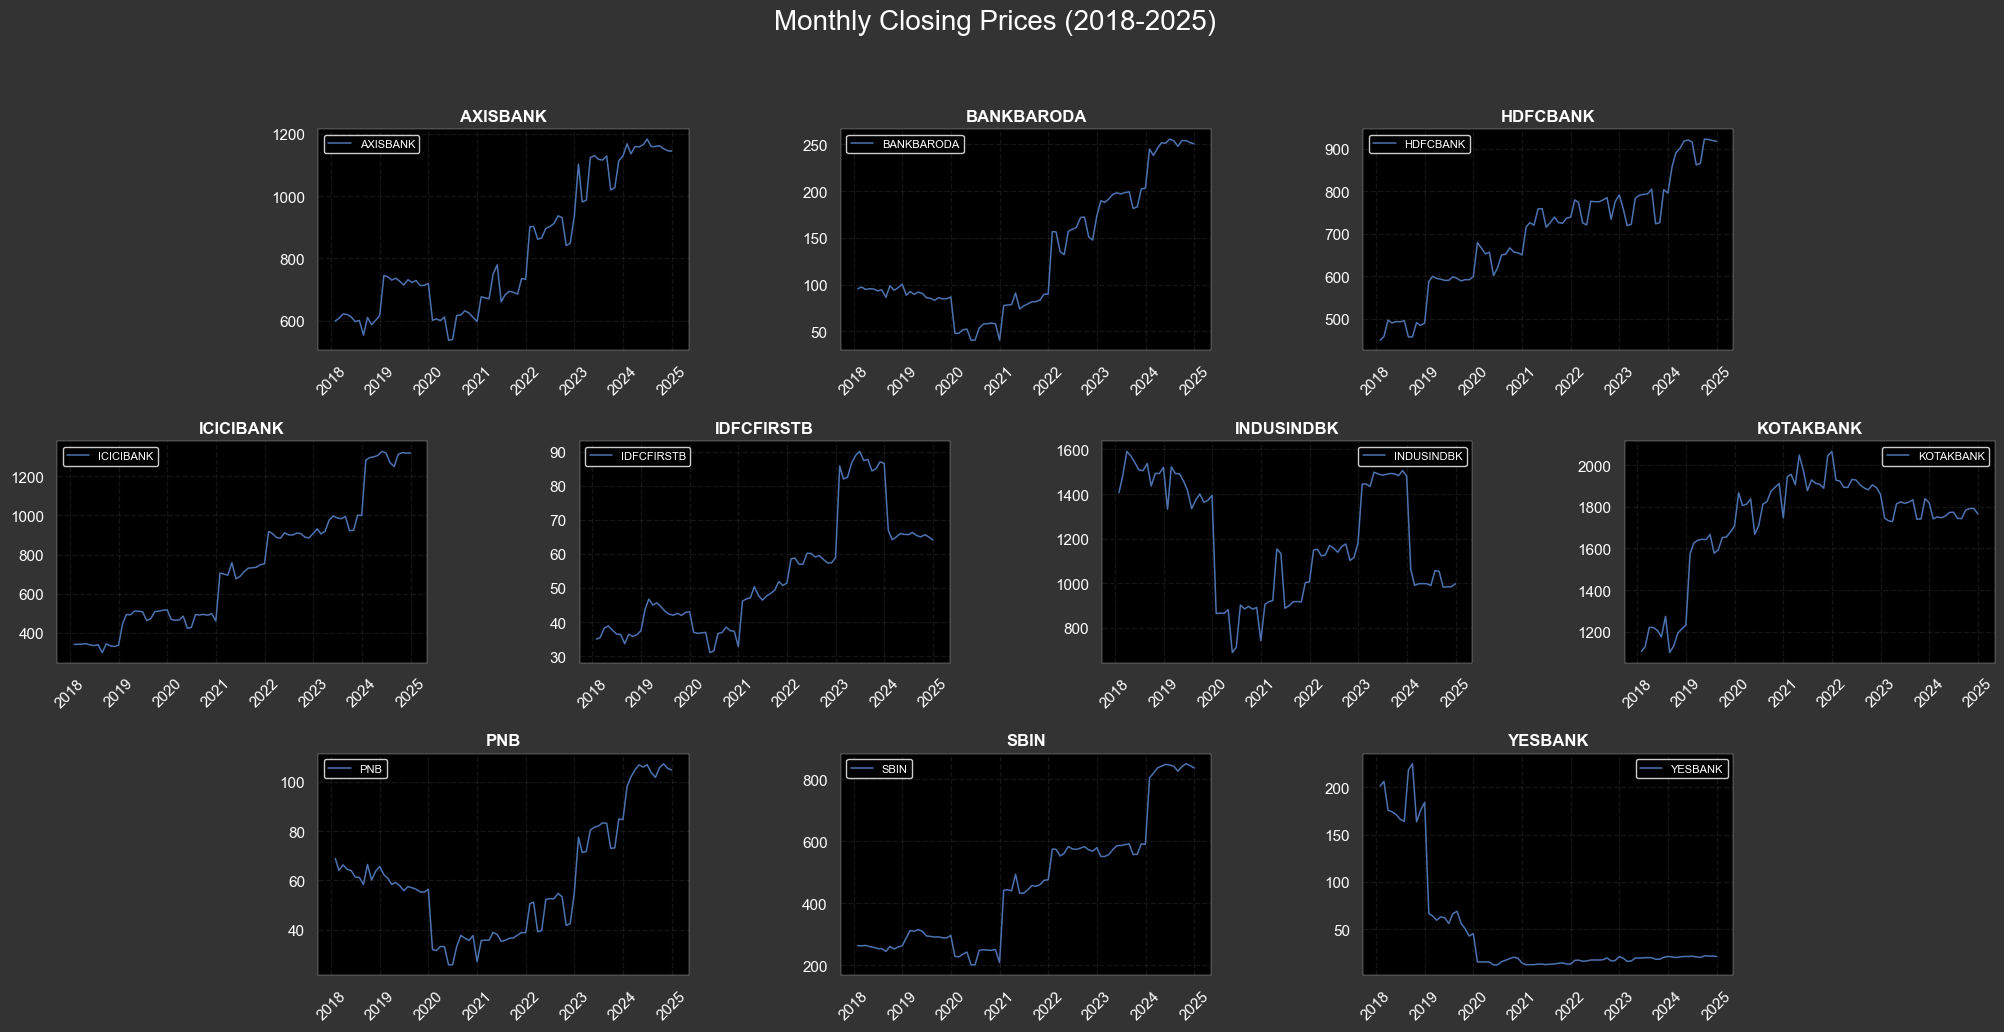

In [20]:
fig=plt.figure( figsize=(25, 12))
gs=gridspec.GridSpec(ncols=15,nrows=12, figure=fig)
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

plt.rcParams.update({
    'figure.facecolor':'#333333',    # entire figure background
    'axes.facecolor': 'black',         # each plot background
    'axes.edgecolor': 'white',         # border color
    'axes.labelcolor': 'white',        # axis label color
    'axes.titlecolor': 'white',        # title color
    'xtick.color': 'white',            # x-axis tick color
    'ytick.color': 'white',            # y-axis tick color
    'grid.color': '#333333',           # subtle grid lines
    'text.color': 'white',             # all text white
    'lines.color': 'white',            # default line color
    'lines.linewidth': 1.1,            # thin lines
    'legend.facecolor': 'black',       # legend background
    'legend.edgecolor': 'white',       # legend border
})


fig.suptitle('Monthly Closing Prices (2018-2025)', fontsize=20, color='white')

ax1=fig.add_subplot(gs[ 0:3,2:5])
ax2=fig.add_subplot(gs[ 0:3,6:9])
ax3=fig.add_subplot(gs[ 0:3,10:13])

ax4=fig.add_subplot(gs[ 4:7,0:3])
ax5=fig.add_subplot(gs[ 4:7,4:7])
ax6=fig.add_subplot(gs[ 4:7,8:11])
ax7=fig.add_subplot(gs[ 4:7,12:15])

ax8=fig.add_subplot(gs[ 8:11,2:5])
ax9=fig.add_subplot(gs[ 8:11,6:9])
ax10=fig.add_subplot(gs[8:11,10:13])

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
tickers = [t for t in stock_data_byMonth['ticker'].unique() if t != 'NSEBANK']

# Reduce border (spine) thickness for all subplots
for ax in fig.axes:
    for spine in ax.spines.values():
        spine.set_linewidth(0.2)  
      



for ax, t in zip(axes, tickers):
    plot_ticker(ax, stock_data_byMonth, t)


plt.show()

#Please run the code once more, some time grapph will be in white background

<h1><b>Total Return Analysis (2018–2024)</b></h1>



In [21]:
total_return = (
    groupByColumn(stock_data.sort_values(['ticker', 'date']), 'ticker')
    .apply(lambda x: pd.Series({
        'mean_close': x['close'].mean(),
        'total_return_pct': (x['close'].iloc[-1] - x['close'].iloc[0]) / x['close'].iloc[0] * 100
    }),
    include_groups=False 
    )
    .sort_values('total_return_pct', ascending=False)
    .reset_index()
    
)

total_return=removeNSE(total_return)



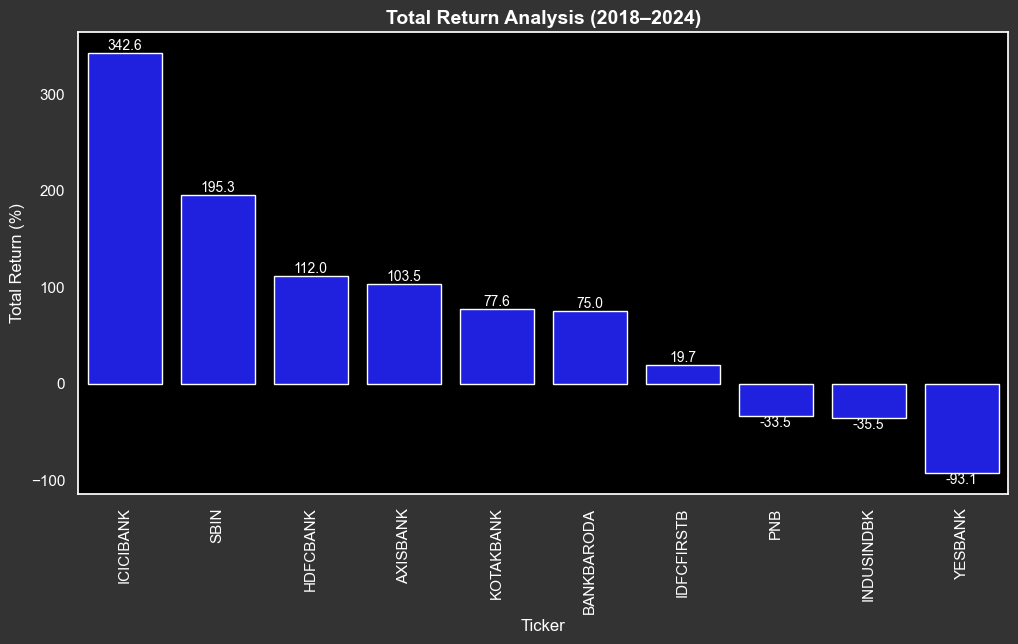

In [22]:
fig,ax=plt.subplots(figsize=(12,6))
sns.barplot(
    data=total_return,
    x='ticker',
    y='total_return_pct',
    color='blue',
    ax=ax
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', fontsize=10, color='white')

graphTuning(
    ax=ax,
    title="Total Return Analysis (2018–2024)",
    xlabel="Ticker",
    ylabel="Total Return (%)"
)
rotateXLabels(ax, angle=90)

plt.show()

## 📈 Insights — Total Return Analysis (2018–2024)

- **ICICI Bank** emerged as the **top performer** with a **342.6% total return**, reflecting consistent growth, strong fundamentals, and investor confidence.  
- **SBI** and **HDFC Bank** also delivered strong multi-year returns (**195%** and **112%**), signaling robust business expansion and stable profitability.  
- **Axis Bank** and **Kotak Mahindra Bank** achieved **moderate returns (75–105%)**, showing steady but less aggressive growth.  
- **Public sector banks like PNB and Bank of Baroda** show **mixed performance** — marginal or negative returns highlight slower recovery despite periodic rallies.  
- **YES Bank** recorded a **-93% total return**, the weakest among peers, due to restructuring and erosion of investor trust post-2019 crisis.  
- The **wide range of returns (from +342% to -93%)** underscores strong **divergence in investor sentiment** and performance across the sector.




<h1><b>Risk and Return Tendency Analysis — Mean vs Median Comparison</b></h1>



In [23]:
stock_data_MVM=(groupByColumn(stock_data,'ticker').agg(
    mean_close=('close', 'mean'),
    median_close=('close', 'median'),
).assign(
  skew_type=lambda x:np.where(x['mean_close']>x['median_close'], 'Positive Skew', 'Negative Skew')
)
.sort_values('mean_close')
.reset_index()
)

stock_data_MVM=removeNSE(stock_data_MVM)


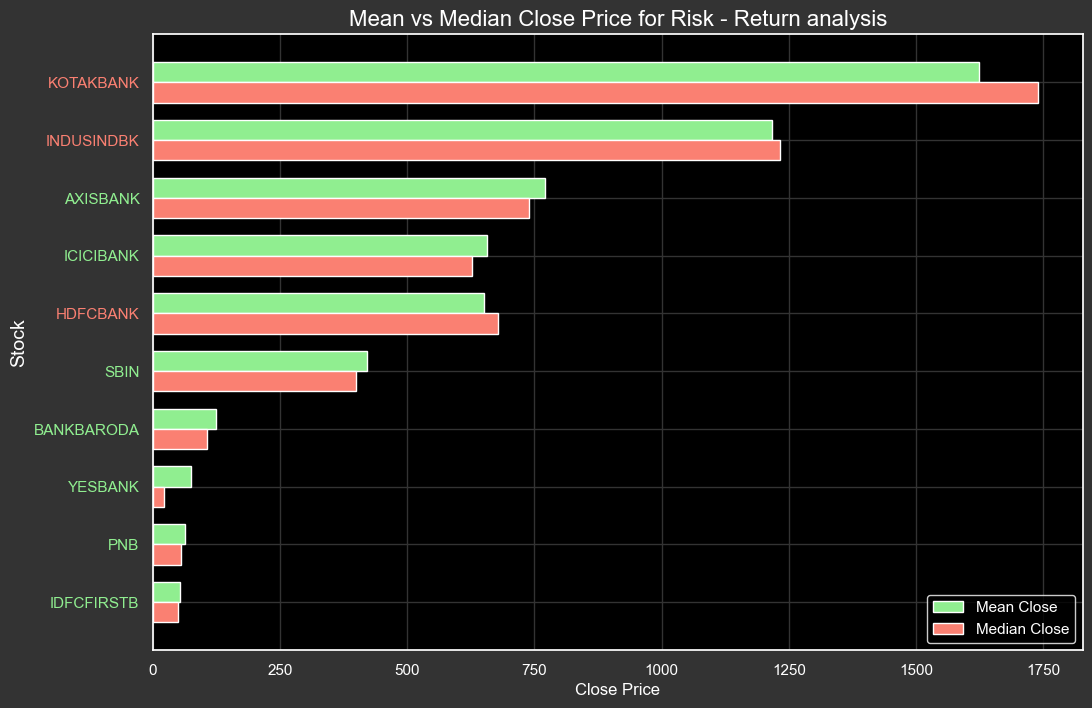

In [24]:
fig,ax=plt.subplots(figsize=(12,8))

width=0.35
x=np.arange(len(stock_data_MVM['ticker']))

ax.barh(x + width/2, stock_data_MVM['mean_close'], width, label='Mean Close', color='lightgreen')
ax.barh(x - width/2, stock_data_MVM['median_close'], width, label='Median Close', color='salmon')
ax.set_yticks(x)
ax.set_yticklabels(stock_data_MVM['ticker'].unique())

for tick_label, skew in zip(ax.get_yticklabels(), stock_data_MVM['skew_type']):
    if skew == 'Positive Skew':
        tick_label.set_color('lightgreen')
    else:
        tick_label.set_color('salmon')

ax.set_xlabel('Close Price',fontsize=12)
ax.set_ylabel('Stock',fontsize=14)
ax.set_title('Mean vs Median Close Price for Risk - Return analysis', fontsize=16)

ax.legend(loc='best')
plt.show()


**One positive skew and negative skew graph**

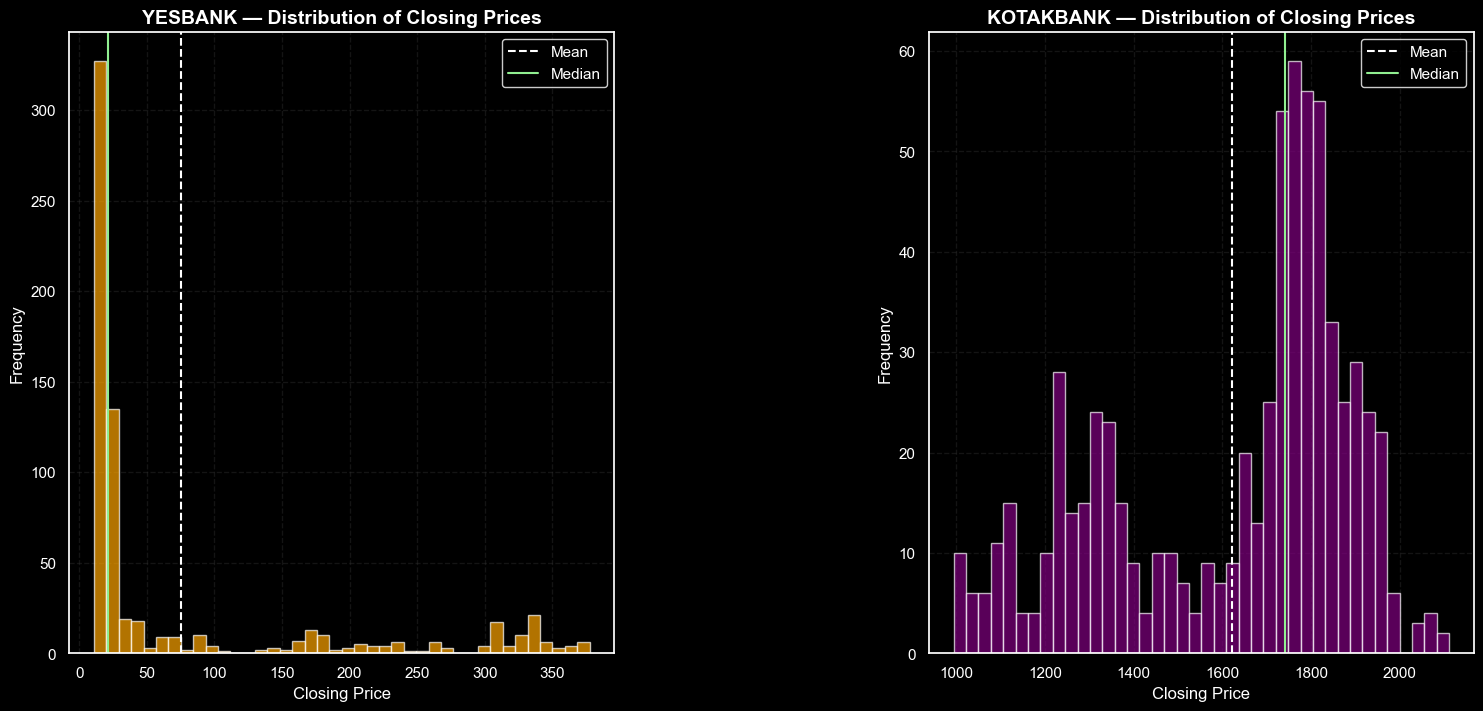

In [25]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(ncols=12, nrows=8, figure=fig)
ax1 = fig.add_subplot(gs[1:8, 0:5])
ax2 = fig.add_subplot(gs[1:8, 7:12])

stock_data=removeNSE(stock_data)

yesbank_data = stock_data[stock_data['ticker'] == 'YESBANK']
kotakbank_data = stock_data[stock_data['ticker'] == 'KOTAKBANK']

# YESBANK Histogram
ax1.hist(yesbank_data['close'], bins=40, color='orange', alpha=0.7)
ax1.axvline(yesbank_data['close'].mean(), color='white', linestyle='--', linewidth=1.5, label='Mean')
ax1.axvline(yesbank_data['close'].median(), color='lightgreen', linestyle='-', linewidth=1.5, label='Median')
graphTuning(
    ax=ax1,
    title='YESBANK — Distribution of Closing Prices',
    xlabel='Closing Price',
    ylabel='Frequency',
    grid=True
)

ax1.legend(facecolor='black', edgecolor='white', labelcolor='white')
ax1.tick_params(colors='white')

# KOTAKBANK Histogram
ax2.hist(kotakbank_data['close'], bins=40, color='purple', alpha=0.7)
ax2.axvline(kotakbank_data['close'].mean(), color='white', linestyle='--', linewidth=1.5, label='Mean')
ax2.axvline(kotakbank_data['close'].median(), color='lightgreen', linestyle='-', linewidth=1.5, label='Median')
graphTuning(
    ax=ax2,
    title='KOTAKBANK — Distribution of Closing Prices',
    xlabel='Closing Price',
    ylabel='Frequency',
    grid=True
)
ax2.legend(facecolor='black', edgecolor='white', labelcolor='white')
ax2.tick_params(colors='white')


fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

## 📊 Insights — Price Distribution Skewness (2018–2024)

- Most banks show **Mean > Median**, indicating a **positively skewed distribution** — driven by **occasional bullish rallies** in prices.  
- **KOTAKBANK**, **HDFCBANK**, and **INDUSINDBK** exhibit a **slight negative skew**, suggesting **steady but less volatile** performance patterns.  
- **YESBANK** stands out with a **high positive skew**, reflecting **sporadic sharp price surges** and heightened volatility.  
- **Overall**, the **banking sector leans positively skewed**, signaling **occasional strong uptrends** amid generally moderate risk exposure.



<h1><b>Yearly Volatility Dynamics — Measuring Market Fluctuations by Price Range (%)</b></h1>



In [26]:
yearly_Price_range=(
  groupByColumn(stock_data,'ticker')
  .resample('YE',on='date')
  .agg(
    price_range=('close',lambda x: x.max()-x.min()),
    close_mean=('close','mean')
  ).assign(
    price_range_pct=lambda x: (x['price_range']/x['close_mean'])*100
  )
  .reset_index()
)
price_range_pivot = yearly_Price_range.pivot_table(
    index='ticker',
    columns=yearly_Price_range['date'].dt.year,  
    values='price_range_pct'
).round(2)

mean_price_change=(yearly_Price_range.groupby('ticker').agg(
    avg_price_range_pct=('price_range_pct','mean') 
))

price_range_pivot
yearly_mean_volatility = price_range_pivot.mean(axis=0).round(2)




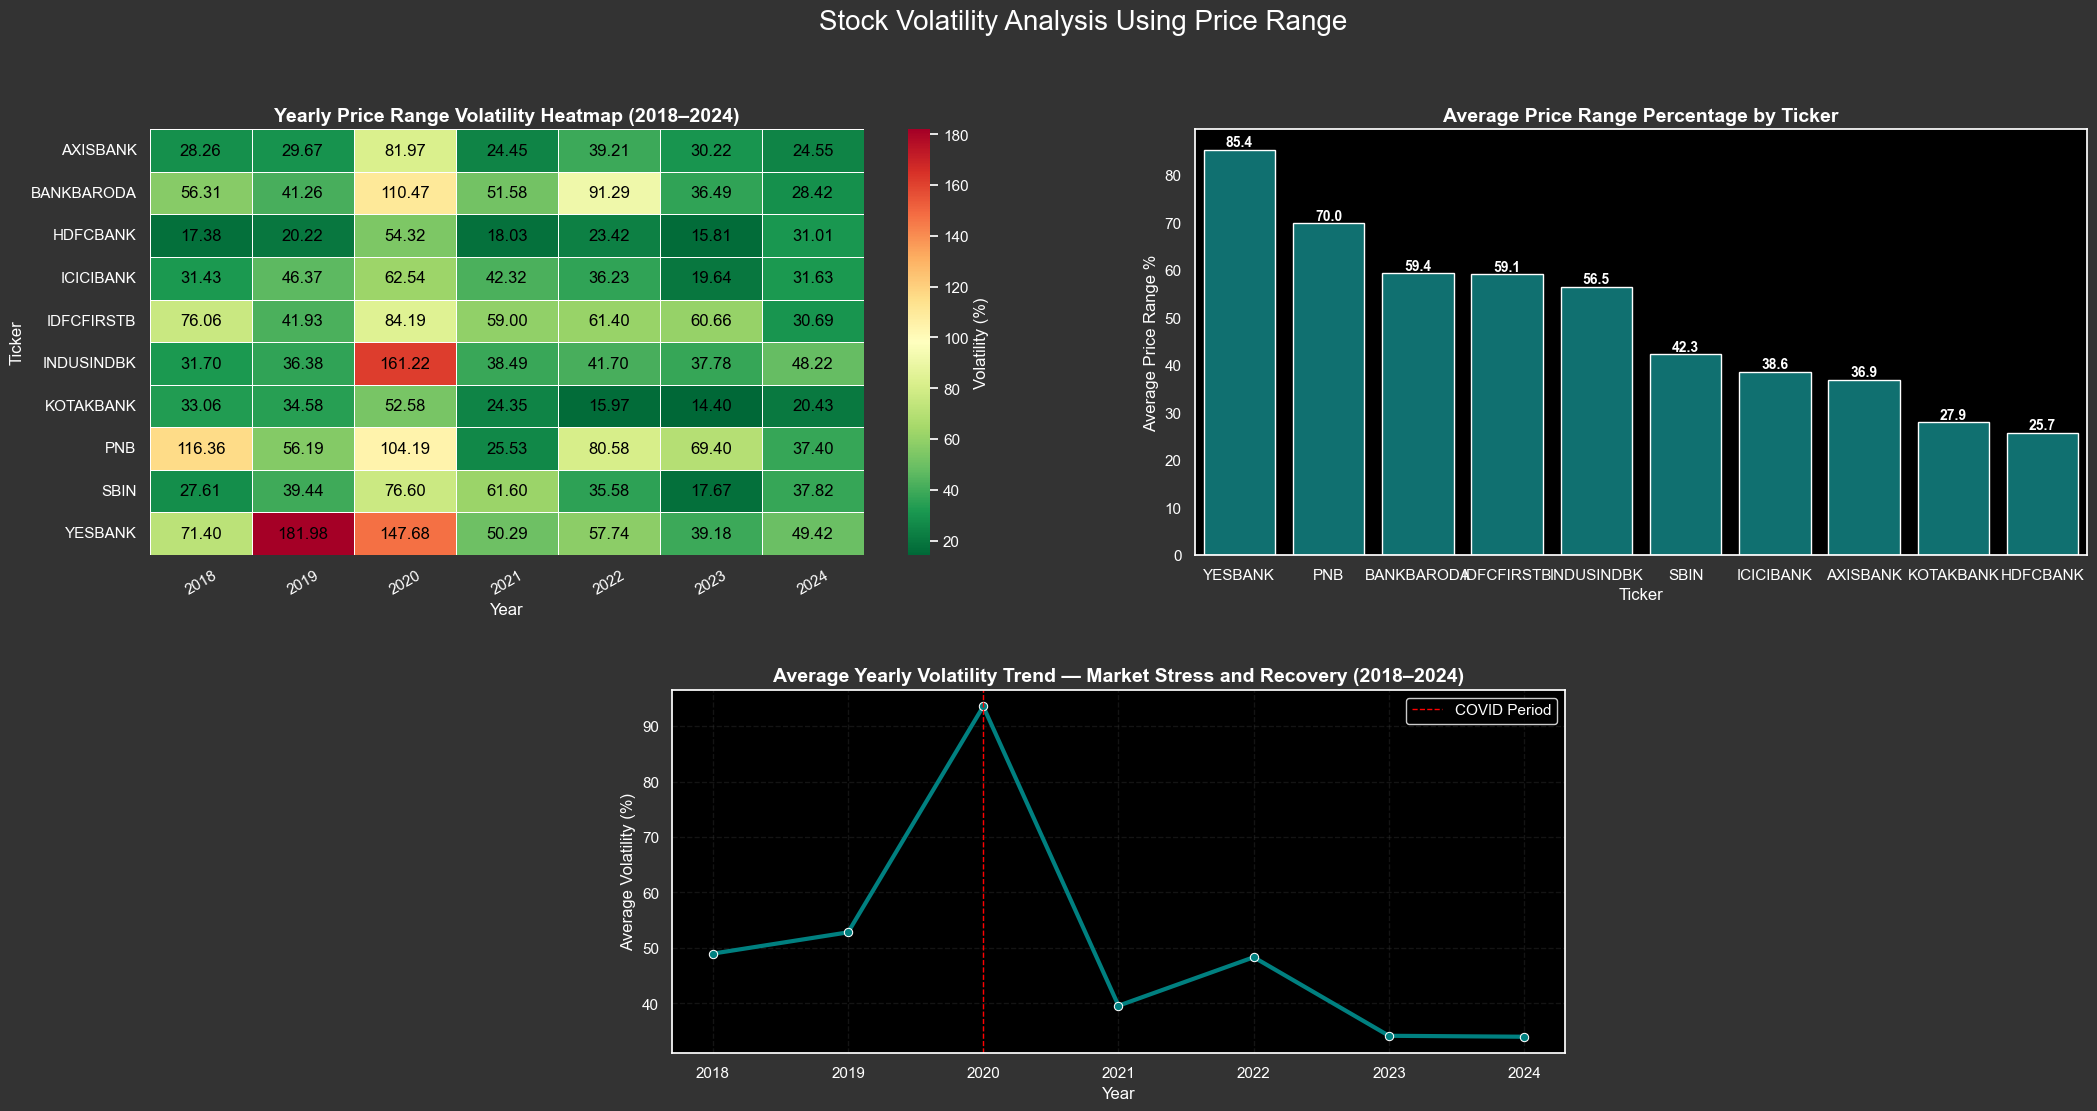

In [27]:
fig = plt.figure(figsize=(25, 12))
gs = gridspec.GridSpec(ncols=15, nrows=15, figure=fig)
ax1 = fig.add_subplot(gs[0:7, 0:7])
ax2 = fig.add_subplot(gs[0:7, 8:15])
ax3 = fig.add_subplot(gs[9:15, 4:11])


sns.heatmap(
    price_range_pivot,
    cmap='RdYlGn_r',    
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Volatility (%)'},
    annot_kws={'color': 'black'}, 
    ax=ax1
)

sns.barplot(
  data=mean_price_change.reset_index().sort_values('avg_price_range_pct', ascending=False),
  y='avg_price_range_pct',
  x='ticker',
  color='teal',
  ax=ax2

)

sns.lineplot(
    x=yearly_mean_volatility.index,
    y=yearly_mean_volatility.values,
    ax=ax3,
    linewidth=3,       
    marker='o',        
    color='teal',    
)


fig.suptitle('Stock Volatility Analysis Using Price Range ', fontsize=20, color='white')

graphTuning(
    ax=ax1,
    title='Yearly Price Range Volatility Heatmap (2018–2024)',
    xlabel='Year',
    ylabel='Ticker',    
)
rotateXLabels(ax1, angle=30)

graphTuning(
    ax=ax2,
    title='Average Price Range Percentage by Ticker',
    xlabel='Ticker',
    ylabel='Average Price Range %',    
)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f', label_type='edge', fontsize=10, color='white',fontweight='bold')

graphTuning(
    ax=ax3,
    title='Average Yearly Volatility Trend — Market Stress and Recovery (2018–2024)',
    xlabel='Year',
    ylabel='Average Volatility (%)',
    grid=True
)

ax3.axvline(x=2020, color='red', linestyle='--', linewidth=1, label='COVID Period')
plt.legend()
plt.show()

## 📈 Insights — Annual Volatility Trends (2018–2024)

- **YESBANK** and **PNB** exhibit **consistently higher annual volatility**, indicating **greater sensitivity to market disruptions** and **elevated risk exposure**.  
- These banks **dominate in average volatility**, underscoring **frequent price fluctuations** and **weaker investor confidence**.  
- **HDFCBANK** and **KOTAKBANK**, by contrast, show **low volatility levels**, reflecting **stability and strong institutional trust**.  
- **Market-wide volatility peaked in 2020**, coinciding with the **COVID-19 crisis**, which introduced **systemic stress** across the financial sector.  
- **Post-2021**, volatility trends show **steady normalization**, suggesting **market recovery** and **renewed investor confidence**, especially in the **last two years**.


<h1><b>Trading Activity & Market Participation — Volume Behavior and Investor Sentiment (2018–2024)</b></h1>



In [28]:
Volume_analysis=(
  groupByColumn(stock_data,'ticker')
  .apply(
    lambda x:pd.Series({
        'total_volume': x['volume'].sum(),
        'price_mean': x['close'].mean(),
        'total_return_pct': (x['close'].iloc[-1] - x['close'].iloc[0]) / x['close'].iloc[0] * 100
    }),
    include_groups=False
  )
  .reset_index()
)
Volume_analysis=removeNSE(Volume_analysis)
Volume_by_Year=stock_data.resample('YE',on='date')[['volume']].sum().reset_index()
Volume_by_Year['date']=Volume_by_Year['date'].dt.year

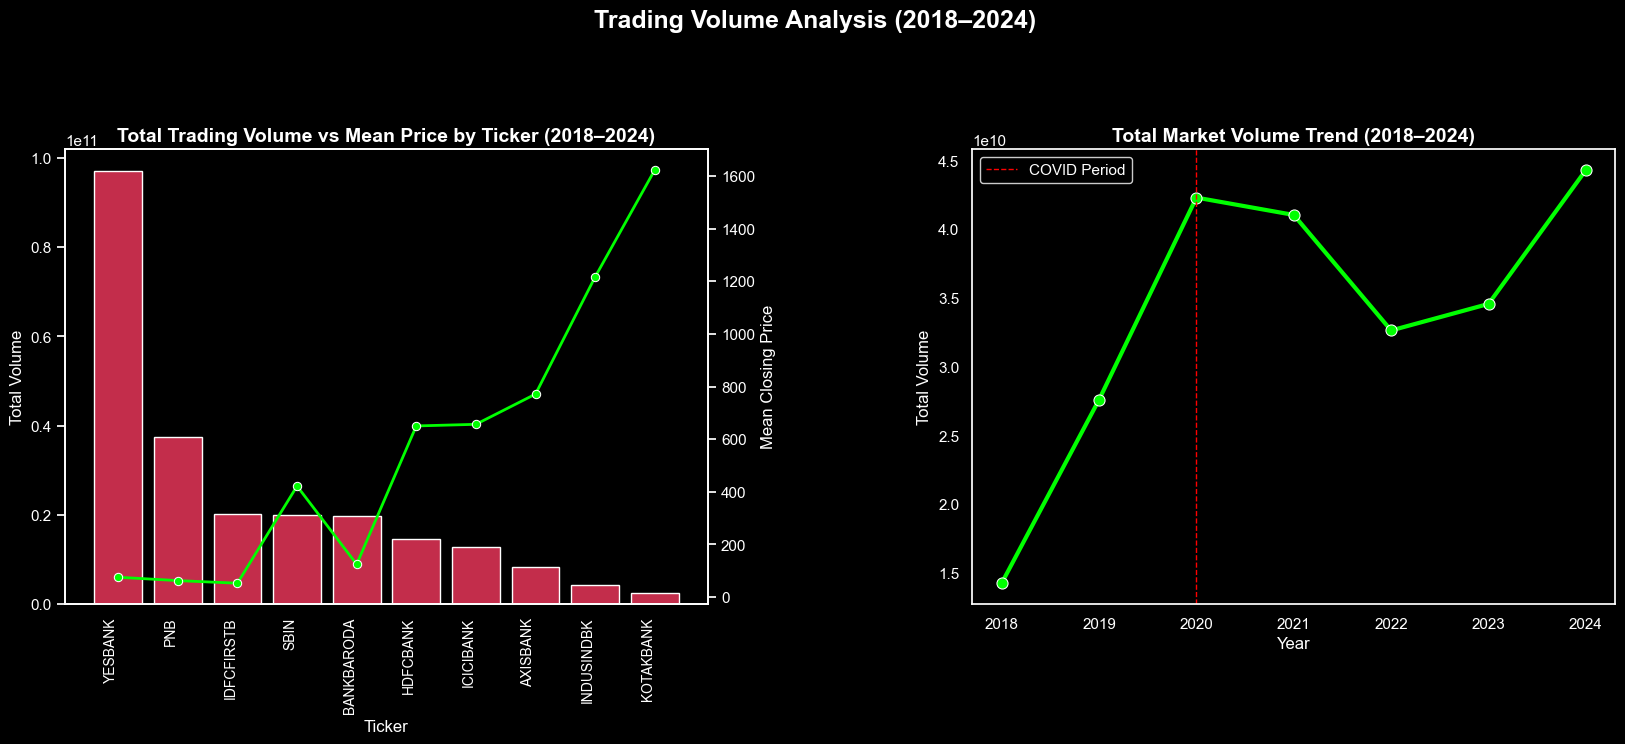

In [29]:
fig = plt.figure(figsize=(20, 14))
gs = gridspec.GridSpec(ncols=7, nrows=14, figure=fig)

ax1 = fig.add_subplot(gs[0:6, 0:3])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[0:6, 4:7])


sns.barplot(
    data=Volume_analysis.sort_values('total_volume', ascending=False),
    x='ticker',
    y='total_volume',
    color='crimson',
    ax=ax1
)
plt.setp(ax1.get_xticklabels(), rotation=90, ha='right', fontsize=10, color='white')

sns.lineplot(
    data=Volume_analysis.sort_values('total_volume', ascending=False),
    x='ticker',
    y='price_mean',
    color='lime',
    linewidth=2,
    marker='o',
    ax=ax2
)


sns.lineplot(
    data=Volume_by_Year,
    x='date',
    y='volume',
    color='lime',
    linewidth=3,
    marker='o',
    markersize=8,
    ax=ax3
)
ax3.axvline(x=2020, color='red', linestyle='--', linewidth=1, label='COVID Period')


fig.suptitle('Trading Volume Analysis (2018–2024)', fontsize=18, color='white', fontweight='bold')

graphTuning(ax=ax1, title="Total Trading Volume vs Mean Price by Ticker (2018–2024)", xlabel="Ticker", ylabel="Total Volume")
graphTuning(ax=ax2, title="", xlabel="", ylabel="Mean Closing Price")
graphTuning(ax=ax3, title="Total Market Volume Trend (2018–2024)", xlabel="Year", ylabel="Total Volume")

ax3.legend(facecolor='black', labelcolor='white')
fig.patch.set_facecolor('black')

plt.show()

## 📊 Insights — Trading Volume Analysis (2018–2024)

- **Lower-priced stocks** such as **YESBANK**, **PNB**, and **IDFCFIRSTB** consistently attract **higher trading volumes**, indicating **strong retail investor participation** driven by **affordability and liquidity**.  
- **High-value banks** like **HDFCBANK** and **KOTAKBANK** show **lower trading volumes** but **higher mean prices**, suggesting **institutional investor dominance** and **long-term holding patterns**.  
- This points to an **inverse relationship between price and trading volume**, where investor activity is influenced more by **accessibility and short-term volatility** than intrinsic valuation.  
- **Trading activity surged in 2020**, aligning with the **COVID-19 period**, as market uncertainty led to **heightened buy–sell momentum** and **speculative trading behavior**.  
- **Post-2020**, volumes remained **consistently elevated**, reflecting the **sustained growth of digital trading platforms** and **retail market participation**.  
- Overall, from **2018 to 2024**, the **steady increase in total traded volume** underscores **improved financial inclusion**, **broader market accessibility**, and **deepening retail engagement** in **India’s banking sector**.


<h1><b>Stock Performance During COVID-19 Pandemic (2020)</b></h1>



In [30]:
corona_2020_yearReturns=(
  groupByColumn(stock_data,'ticker')
  .resample('YE',on='date')
  .agg(
    year_start_price=('close',lambda x: x.iloc[0]),
    year_end_price=('close',lambda x: x.iloc[-1])
  ).assign(
    year_return_pct=lambda x: ((x['year_end_price'] - x['year_start_price'])/x['year_start_price'])*100
  )
  .reset_index()
  .query("date.dt.year == 2020")
  .drop(columns=['date'])
  .set_index('ticker')
  .sort_values('year_return_pct', ascending=False)
)

corona_2020_fluctuations=(
  groupByColumn(stock_data,'ticker')
  .resample('YE',on='date')
  .agg(
    year_max_price=('close','max'),
    year_min_price=('close','min')
  ).assign(
    year_fluctuation_pct=lambda x: ((x['year_max_price'] - x['year_min_price'])/x['year_min_price'])*100
  )
  .reset_index()
  .query("date.dt.year == 2020")
  .drop(columns=['date'])
  .set_index('ticker')
  .sort_values('year_fluctuation_pct')
)



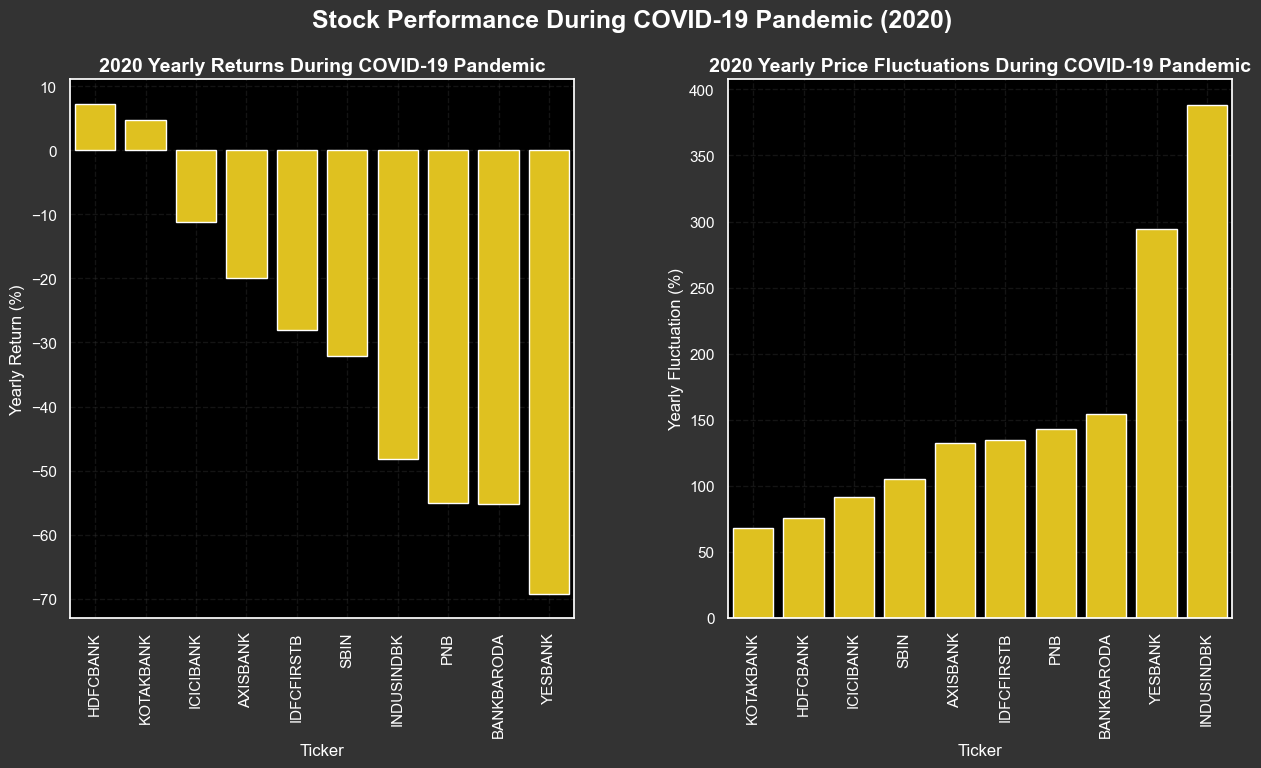

In [31]:
fig=plt.figure(figsize=(15,7))
gs=gridspec.GridSpec(ncols=9,nrows=1, figure=fig)
ax1=fig.add_subplot(gs[0:1,0:4])
ax2=fig.add_subplot(gs[0:1,5:9])

sns.barplot(
  data=corona_2020_yearReturns.reset_index(),
  x='ticker',
  y='year_return_pct',
  color='gold',
  ax=ax1
)

sns.barplot(
  data=corona_2020_fluctuations.reset_index(),
  x='ticker',
  y='year_fluctuation_pct',
  color='gold',
  ax=ax2
)
fig.suptitle('Stock Performance During COVID-19 Pandemic (2020)', fontsize=18, color='white', fontweight='bold')

rotateXLabels(ax1, angle=90)
rotateXLabels(ax2, angle=90)

graphTuning(
    ax1,
    title="2020 Yearly Returns During COVID-19 Pandemic",
    xlabel="Ticker",
    ylabel="Yearly Return (%)",
    grid=True
)

graphTuning(
    ax2,
    title="2020 Yearly Price Fluctuations During COVID-19 Pandemic",
    xlabel="Ticker",
    ylabel="Yearly Fluctuation (%)",
    grid=True
)

plt.show()

## 🦠 Stock Performance During COVID-19 Pandemic (2020) — Insights

- **HDFCBANK and KOTAKBANK** demonstrated remarkable resilience during the COVID-19 shock — 
  showing the **highest yearly returns** and **lowest price fluctuations**, indicating strong fundamentals and investor confidence.

- **YESBANK** and **PNB** exhibited both **negative returns** and **extreme volatility**, highlighting weaker financial stability and market sentiment during crisis periods.

- **INDUSINDBK** recorded the **highest price fluctuation (~400%)**, suggesting significant speculative trading or investor panic during market uncertainty.

- **Mid-tier banks** like **AXISBANK** and **SBIN** faced moderate losses but maintained relative stability compared to high-volatility players, reflecting solid recovery potential.

- The **inverse relationship between fluctuation and return** reveals that **banks with disciplined risk management** and robust balance sheets not only survived but **outperformed** during the COVID crash.

- Overall, the data underscores that **fundamentally strong, well-capitalized private sector banks** (HDFC, ICICI, KOTAK) 
  provided **better downside protection** and **faster recovery**, whereas **public and smaller private banks** struggled to sustain investor confidence.


## 📊 Correlation Analysis Between Bank Stocks (2018–2024)


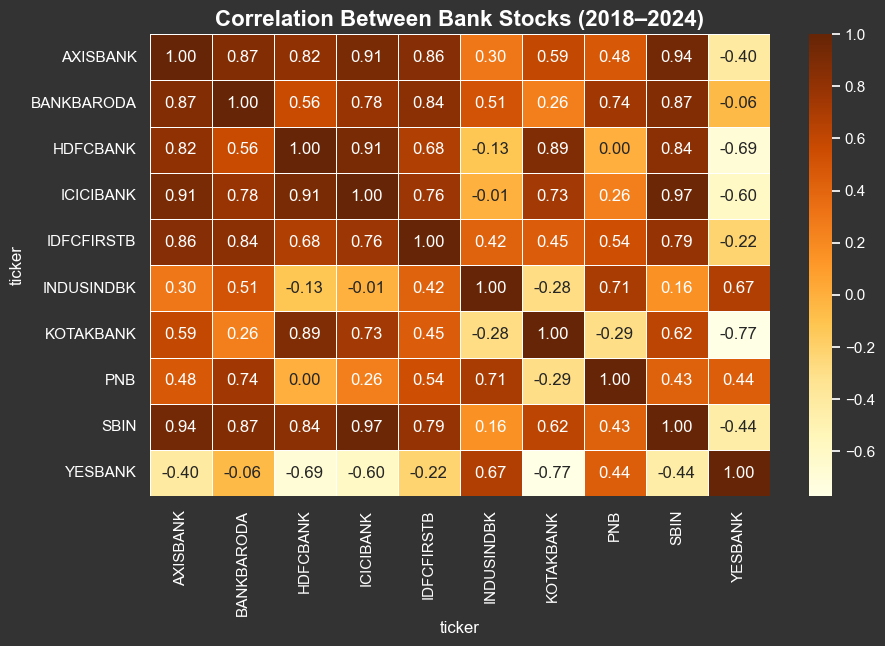

In [32]:
# Pivot the data to get closing prices of each ticker across time
price_pivot = stock_data.pivot(index='date', columns='ticker', values='close')

# Compute correlation matrix
corr_matrix = price_pivot.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='YlOrBr',
    linewidths=0.5,
    fmt=".2f"
)
plt.title('Correlation Between Bank Stocks (2018–2024)', fontsize=16, weight='bold')
plt.show()


## 🔍 Correlation Insights (2018–2024)

- **HDFCBANK, ICICIBANK, and KOTAKBANK** show very high correlation (≈0.9+), suggesting they move together during most market phases.  
- **AXISBANK and SBIN** are moderately correlated with private banks, indicating similar but not identical trends.  
- **YESBANK and INDUSINDBK** show weaker correlation with others, highlighting independent or speculative behavior patterns.  
- High correlation clusters (like HDFC–ICICI–KOTAK) imply **sectoral risk**, meaning market shocks can impact them together.  
- Lower correlation players may offer **diversification benefits** in a banking-sector portfolio.
